In [90]:
import os

import av
import cv2
import numpy as np
import pandas as pd
from torchvision import models
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from utils.video_processing import sample_frame_indices, read_video_pyav, apply_video_augmentations
from transformers import AutoProcessor, AutoModel, VideoMAEImageProcessor, VideoMAEForVideoClassification

In [91]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [149]:
batch_size = 32
root_dir = 'UCF-101/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pretrained transformer model

In [150]:
model = models.vgg11(pretrained=True)
model.fc = nn.Linear(512, 15)
model.to(device)

C:\Users\user\anaconda3\envs\cv-base\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\cv-base\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Dataset preparation

In [151]:
df = pd.read_csv("data\kinetics_700\dancing.csv")
df["video_path"] = "data/kinetics_700/clips_2/" + df["youtube_id"] + ".mp4"
df.head()

,Unnamed: 0,label,youtube_id,time_start,time_end,split,video_path
0,23948,belly dancing,uhX8rmHFLaY,116,126,train,data/kinetics_700/clips_2/uhX8rmHFLaY.mp4
1,23843,belly dancing,-q0Wpf0WThk,317,327,train,data/kinetics_700/clips_2/-q0Wpf0WThk.mp4
2,24142,belly dancing,P9mOEmlCEXY,62,72,train,data/kinetics_700/clips_2/P9mOEmlCEXY.mp4
3,23467,belly dancing,mm5S2ftbb-k,32,42,train,data/kinetics_700/clips_2/mm5S2ftbb-k.mp4
4,23982,belly dancing,TCbfIBb87hQ,134,144,train,data/kinetics_700/clips_2/TCbfIBb87hQ.mp4


In [152]:
print("Before:", df.shape[0])
for i, row in df.iterrows():
    if not os.path.exists(row['video_path']):
        print(row['video_path'])
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)
print("After:", df.shape[0])

Before: 3000
data/kinetics_700/clips_2/PL3ex5IAQNw.mp4
data/kinetics_700/clips_2/NJAIp24I9oQ.mp4
data/kinetics_700/clips_2/_ubj_hjLdVc.mp4
data/kinetics_700/clips_2/iQuTmRkOuIo.mp4
data/kinetics_700/clips_2/Y_rtxFTnyWI.mp4
data/kinetics_700/clips_2/cNvTm72aGcM.mp4
data/kinetics_700/clips_2/YUJVnjzPZxI.mp4
data/kinetics_700/clips_2/ooN3OOKuAjY.mp4
data/kinetics_700/clips_2/sbvNyPubcFM.mp4
data/kinetics_700/clips_2/g3E8Cjog6-k.mp4
data/kinetics_700/clips_2/iJ5KAamDDP8.mp4
data/kinetics_700/clips_2/kuJO1VapxuQ.mp4
data/kinetics_700/clips_2/G0MfJoTOAOw.mp4
data/kinetics_700/clips_2/yEEDk2CMOTI.mp4
data/kinetics_700/clips_2/zt7XHcgHdEc.mp4
data/kinetics_700/clips_2/Sw4Ggaya3ys.mp4
data/kinetics_700/clips_2/xeemkepaczg.mp4
data/kinetics_700/clips_2/s5GJdHQL_Wc.mp4
data/kinetics_700/clips_2/N4UtAez9QVE.mp4
data/kinetics_700/clips_2/0sCg3fIcMCA.mp4
data/kinetics_700/clips_2/NLhhoE7es8g.mp4
data/kinetics_700/clips_2/uvoBn-8AxHI.mp4
data/kinetics_700/clips_2/F60UViJTih0.mp4
data/kinetics_700/cli

In [153]:
X_train, X_val, _, _ = train_test_split(df, df['label'])
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

In [154]:
labels = X_train["label"].unique()
labels2id = {label: i for i, label in enumerate(labels)}

In [155]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.5)
], additional_targets={
    f'image{i}': 'image' for i in range(1, 8)
})

to_tensor = ToTensor()

In [156]:


class ActionDataset(Dataset):

    def __init__(self, meta, transform=None):
        self.meta = meta
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        while True:
            try:
                file_path = self.meta['video_path'].iloc[idx]
                container = av.open(file_path)

                indices = sample_frame_indices(clip_len=8, frame_sample_rate=5,
                                               seg_len=container.streams.video[0].frames)
                video = read_video_pyav(container, indices)
                # while video.shape[0] < 8:
                #     video = np.vstack([video, video[-1:]])

            except Exception as e:
                print("loop Error: ", e)
                continue
            break

        if self.transform:
            transformed = apply_video_augmentations(video, self.transform)
            video = transformed

        return video, self.meta['label'].iloc[idx]

    def validate_videos(self):
        for i, row in self.meta.iterrows():
            if not os.path.exists(row['video_path']):
                print(row['video_path'])
                self.meta.drop(i, inplace=True)
                continue

            self.__getitem__(i)
        self.meta.reset_index(drop=True, inplace=True)
        return self.meta

In [157]:
class VideoDataset(Dataset):
    def __init__(self, meta, max_length=128, transform=None):
        self.meta = meta
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        video = self.load_video(row['video_path'])
        video = apply_video_augmentations(video, self.transform)
        # video = to_tensor(video)
        labels_tensor =  labels2id[self.meta['label'].iloc[idx]]
        return to_tensor(video[4]), labels_tensor

    def load_video(self, path):
        container = av.open(path)
        indices = sample_frame_indices(clip_len=8, frame_sample_rate=5,
                                               seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container, indices)
        frames = []
        for frame in video:
            frame = cv2.resize(frame.to_ndarray(format="rgb24"), (224, 224))
            frame = to_tensor(frame)
            frames.append(frame)
        return np.stack([x for x in frames])

# Training

In [158]:
# clear gpu memory
import gc

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

gc.collect()
torch.cuda.empty_cache()

In [159]:
train_dataset = VideoDataset(meta=X_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [162]:
test_dataset = VideoDataset(meta=X_val, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [160]:
train_dataset[0][0].shape

torch.Size([224, 3, 224])

In [140]:
one_image = train_dataset[0][0]
one_image.shape

torch.Size([224, 3, 224])

In [161]:
epochs = 10
lr = 1e-3

optimizer = optim.AdamW(model.parameters(), lr)  # 289
loss_fun = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):

    model.train()

    train_loss = []
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch: {epoch}")):

        inputs, Y = batch
        inputs = torch.swapaxes(inputs, 1, -2)
        inputs = inputs.to(device, dtype=torch.float32)
        Y = Y.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(inputs).to(device)
        preds = torch.softmax(outputs, dim=1).to(device)

        loss = loss_fun(preds, Y.long())
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    print('Training loss:', np.mean(train_loss))

    model.eval()

Epoch: 0:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.672688690515665


Epoch: 1:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.673147277954297


Epoch: 2:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.672899439930916


Epoch: 3:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.6718875646591185


Epoch: 4:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.6712742440211468


Epoch: 5:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.6705205931768314


Epoch: 6:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.6710254727647853


Epoch: 7:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.670088915233938


Epoch: 8:   0%|          | 0/52 [00:00<?, ?it/s]

Training loss: 2.672923018840643


Epoch: 9:   0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(),'resnet34_20.pkl')


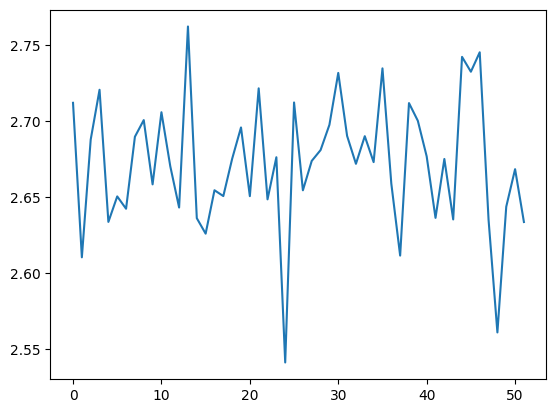

In [164]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(train_loss)

In [ ]:
val_targets = []
val_preds = []
val_dataset = ActionDataset(meta=X_val)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

for i, batch in enumerate(tqdm(val_dataloader)):
    batch = batch.to(device)

    with torch.no_grad():
        outputs = model(**batch)

    logits_per_video = outputs.logits_per_video
    probs = logits_per_video.softmax(dim=1)

    val_targets.append(labels2id[val_dataset.meta.iloc[i]['label']])
    val_preds.append(probs.argmax(axis=1).cpu().numpy()[0])

print('F1:', f1_score(val_targets, val_preds, average='macro'))

In [ ]:
# empty gpu memory
import gc

gc.collect()
torch.cuda.empty_cache()
